In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import warnings
import sys
import subprocess
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

model_name = "roberta-large-mnli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
ds = load_dataset("wangrongsheng/ag_news")


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [ ]:
# def start_gemma2_session():
#     """
#     Start Gemma2 through Ollama and return the process instance.

#     Returns:
#         subprocess.Popen: Persistent Gemma2 process.
#     """
#     gemma2_process = subprocess.Popen(
#         ["ollama", "run", "gemma2"],
#         stdin=subprocess.PIPE,
#         stdout=subprocess.PIPE,
#         stderr=subprocess.PIPE,
#         text=True
#     )
#     return gemma2_process


In [ ]:
# def interact_with_gemma2(gemma2_process, prompt):
#     """
#     Send a prompt to Gemma2 and retrieve its response.

#     Args:
#         gemma2_process (subprocess.Popen): The running Gemma2 process.
#         prompt (str): The prompt to send.

#     Returns:
#         str: The response from Gemma2.
#     """
#     # Write the prompt to Gemma2
#     gemma2_process.stdin.write(prompt + "\n")
#     gemma2_process.stdin.flush()

#     # Read the response
#     response = gemma2_process.stdout.readline().strip()
#     return response



In [3]:
classifier = pipeline('zero-shot-classification', model=model_name, device=1)                              
sequence_to_classify = "This is a test"
candidate_labels = ['travel', 'cooking', 'dancing', 'technician', 'teacher']
classifier(sequence_to_classify, candidate_labels)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'sequence': 'This is a test',
 'labels': ['technician', 'travel', 'teacher', 'dancing', 'cooking'],
 'scores': [0.4375876188278198,
  0.17017927765846252,
  0.16035453975200653,
  0.13061025738716125,
  0.10126830637454987]}

In [4]:
def perform_error_analysis(dataset, classifier, label_map, num_samples=100):
    """
    Perform comprehensive error analysis on the zero-shot classifier.
    Returns the analysis results as a string and the results DataFrame.
    
    Args:
        dataset: The AG News dataset
        classifier: The zero-shot classification pipeline
        label_map: Dictionary mapping label indices to descriptions
        num_samples: Number of samples to analyze (use smaller number for testing)
    """
    output_string = ""
    
    # Prepare candidate labels for zero-shot classification
    candidate_labels = list(label_map.values())
    output_string += f"Candidate labels: {candidate_labels}\n\n"
    
    # Store results
    results = []
    
    # Process test samples
    for i, item in tqdm(enumerate(dataset['test']), total=num_samples):
        if i >= num_samples:
            break
            
        text = item['text']
        true_label = label_map[item['label']]
        
        # Get model prediction
        prediction = classifier(text, candidate_labels)
        predicted_label = prediction['labels'][0]
        confidence = prediction['scores'][0]
        
        results.append({
            'text': text,
            'true_label': true_label,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'correct': true_label == predicted_label
        })
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    # 1. Overall Accuracy
    accuracy = (df_results['correct'].sum() / len(df_results)) * 100
    output_string += f"Overall Accuracy: {accuracy:.2f}%\n\n"
    
    # 2. Per-class Performance
    output_string += "Per-class Performance:\n"
    class_report = classification_report(df_results['true_label'], df_results['predicted_label'])
    output_string += f"{class_report}\n"
    
    # 5. Error Examples Analysis
    output_string += "Most Confident Mistakes:\n"
    mistakes = df_results[~df_results['correct']].sort_values('confidence', ascending=False)
    mistake_df = mistakes[['text', 'true_label', 'predicted_label', 'confidence']].head()
    output_string += mistake_df.to_string()
    output_string += "\n"

    return df_results, output_string, accuracy

In [5]:
from collections import defaultdict

def analyze_error_patterns(df_results):
    """
    Analyze specific patterns in the errors and return them as a string.
    """
    # Common misclassification patterns
    error_patterns = defaultdict(int)
    for _, row in df_results[~df_results['correct']].iterrows():
        pattern = f"{row['true_label']} → {row['predicted_label']}"
        error_patterns[pattern] += 1

    # Collect the output lines in a list
    output_lines = ["\nCommon Error Patterns:"]
    for pattern, count in sorted(error_patterns.items(), key=lambda x: x[1], reverse=True):
        output_lines.append(f"{pattern}: {count}")

    # Join the lines into a single string and return
    # print("\n".join(output_lines))
    return "\n".join(output_lines)

        
    # # Confidence threshold analysis
    # thresholds = np.arange(0.1, 1.0, 0.1)
    # accuracies = []
    # coverage = []
    
    # for threshold in thresholds:
    #     filtered_preds = df_results[df_results['confidence'] >= threshold]
    #     if len(filtered_preds) > 0:
    #         acc = (filtered_preds['correct'].sum() / len(filtered_preds)) * 100
    #         cov = (len(filtered_preds) / len(df_results)) * 100
    #         accuracies.append(acc)
    #         coverage.append(cov)
    
    # # Ensure arrays are the same length before plotting
    # min_len = min(len(accuracies), len(coverage))
    # thresholds = thresholds[:min_len]
    # accuracies = accuracies[:min_len]
    # coverage = coverage[:min_len]
    
    # if min_len > 0:  # Only plot if we have data
    #     plt.figure(figsize=(10, 6))
    #     plt.plot(thresholds, accuracies, 'b-', label='Accuracy')
    #     plt.plot(thresholds, coverage, 'r-', label='Coverage')
    #     plt.xlabel('Confidence Threshold')
    #     plt.ylabel('Percentage')
    #     plt.title('Accuracy vs Coverage Trade-off')
    #     plt.legend()
    #     plt.grid(True)
    #     plt.show()
    # else:
    #     print("Warning: Not enough data points to create accuracy-coverage plot")


STOP

In [ ]:
# # Example usage
# if __name__ == "__main__":
#     # Initialize Gemma2 session
#     gemma2 = start_gemma2_session()

#     # Initial prompt
#     initial_prompt = "You are an expert prompt generator for a zero shot text classification task. I am using roberta-large-mnli to do zero shot classification on the ag news dataset. I will first provide you with the truth labels corresponding to the 4 types of texts in the ag news dataset (in total the dataset has over one hundred thousand different texts then iteratively I will provide you with the current prompts that have been given to the model and the corresponding accuracy of the model per label on the task, I want you to provide better prompts for all the four labels so that the accuracy of the model improves. We will have many iterations of this process and I want you to iteratively give better prompts. Your output should be of the format 0: \"prompt0\", 1: \"prompt1\", 2: \"prompt2\", 3: \"prompt3\" (without the \ because that's only for passing double string to you in python) where the values of the dictionary correspond to the prompts that you generate. Do not generate any text other than these prompts in dictionary format. If after 2-3 iterations the accuracy doesn't increase by much than try different methods. Also if you are able to achieve precision of over 90 for any of the four labels then don't change the prompt for those by much."
#     current_prompt = initial_prompt

#     # Iteratively refine the prompt using Gemma2
#     iterations = 3
#     for i in range(iterations):
#         print(f"Iteration {i + 1}: Current Prompt -> {current_prompt}")
#         refined_prompt = interact_with_gemma2(gemma2, current_prompt)
#         print(f"Refined Prompt -> {refined_prompt}")
#         current_prompt = refined_prompt

#         # Use the refined prompt for classification
#         print("\nUsing the final refined prompt for analysis...")
#         candidate_labels = [f"{refined_prompt} ({label})" for label in ["politics", "sports", "economics", "science and technology"]]

#         # Perform main error analysis with the refined prompt
#         results_df = perform_error_analysis(ds, classifier, num_samples=500, prompt=refined_prompt)
        
#         # Analyze error patterns
#         analyze_error_patterns(results_df)

#     # Terminate Gemma2 session
#     gemma2.terminate()

In [6]:
# from ollama import chat

# models = ['nemotron']

message = '''You are an expert prompt generator for a zero shot text classification task. I am using roberta-large-mnli to do zero shot classification on the ag news dataset.  
I will first provide you with the truth labels corresponding to the 4 types of texts in the ag news dataset (in total the dataset has over one hundred thousand different texts). 
The AG News dataset provides us with the following intial labels: 0: World, 1: Sports, 2: Business, 4: Sci/Tech
Then iteratively, I will provide you with the current prompts that have been given to the model and the corresponding accuracy of the model per label on the task.
I want you to provide better prompts for all the four labels so that the accuracy of the model improves. We will have many iterations of this process and I want you to iteratively give better prompts.
I will also give you the per class accuracy, the most confident mistakes, and common error patterns observed for the given labels. Infer whatever you want to from them and try to make your results better.(Follow the format exactly, dont miss any commas or inverted commas)
Your output should be of the format 0: \"prompt0\", 1: \"prompt1\", 2: \"prompt2\", 3: \"prompt3\" where the values of the dictionary correspond to the prompts that you generate. (The prompts aren't questions, they are assertions)
Do not generate any text other than these prompts in dictionary format. If after 2-3 iterations the accuracy doesn't increase by much than try different methods. 
Also if you are able to achieve precision of over 90 for any of the four labels then don't change the prompt for those by much.
This is my initial input to you, from the next message onwards, I will start giving the above mentioned data as the message, I won't provide any other information in the subsequent messages, so use the information I gave in this message to interpret the data provided.
Also, don't give any non alphanumeric characters in the output such as emojis or emoticons. 
Overall Accuracy: 48.50%

Per-class Performance:
              precision    recall  f1-score   support

    Business       0.36      0.08      0.13       205
    Sci/Tech       0.91      0.21      0.34       253
      Sports       0.75      0.68      0.72       274
       World       0.35      0.85      0.50       268

    accuracy                           0.48      1000
   macro avg       0.60      0.46      0.42      1000
weighted avg       0.61      0.48      0.44      1000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                    text  \
702                                                                                                                                  HP Unveils Cavalcade of Consumer Products (PC World) PC World - First TVs, new printers, long-lasting inks, and projectors are targeted\ at living room and office.   
624  World #39;s smallest digital camera with zoom lens Come September, Japanese electronics giant Casio Computer will launch the world #39;s smallest digital camera with a zoom lens. Casio #39;s palm-sized Exilim camera is much smaller than others as, for the first time, it uses a ceramic lens.   
468                                                                                              Microsoft: Use Script to Block Windows XP SP2 Updates Microsoft has offered up yet another way for businesses to block the automatic update of Windows XP to the big-deal Service Pack 2 (SP2) upgrade.   
821                                                                                                  We owe Athens an apology ATHENS -- The Games of the XXVIII Olympiad -- the great disaster that wasn #39;t -- come to an emotional end this afternoon and, really, the world owes Athens an apology.   
963                                       EU, Japan Win WTO Approval to Impose Duties on US (Update2) The European Union, Japan and Brazil won World Trade Organization backing to impose tariffs on US imports after Congress failed to end illegal corporate subsidies worth \$850 million since 2001.   

    true_label predicted_label  confidence  
702   Sci/Tech           World    0.952798  
624   Sci/Tech           World    0.937181  
468   Sci/Tech        Business    0.881427  
821     Sports           World    0.867683  
963   Business           World    0.826846  


Common Error Patterns:
Business → World: 173
Sci/Tech → World: 160
Sports → World: 87
World → Sports: 36
Sci/Tech → Business: 28
Business → Sports: 14
Sci/Tech → Sports: 12
World → Sci/Tech: 3
Business → Sci/Tech: 2

(print only in the format described and print nothing else, don't forget the double quotations for the prompts)
    Output format: {0: "prompt0", 1: "prompt1", 2: "prompt2", 3: "prompt3"}

'''

# for i in models:
#   print("Model name:", i)
#   stream = chat(
#       model=i,
#       messages=[{'role': 'user', 'content': message}],
#       stream=True,
#   )
  
#   for chunk in stream:
#     print(chunk['message']['content'], end='', flush=True)
#   print()


Iteration 1: Current label prompts:
0: "World"
1: "Sports"
2: "Business"
4: "Sci/Tech"
{0: "This article discusses global events and international news.", 1: "This text is about athletic competitions, players, and teams.", 2: "The content here involves corporate affairs, market trends, and financial news.", 3: "This piece focuses on technological advancements or scientific discoveries."}

Iteration 2: Current label prompts:
0: "This article discusses global events and international news."
1: "This text is about athletic competitions, players, and teams."
2: "The content here involves corporate affairs, market trends, and financial news."
3: "This piece focuses on technological advancements or scientific discoveries."


  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This article discusses global events and international news.', 1: 'This text is about athletic competitions, players, and teams.', 2: 'The content here involves corporate affairs, market trends, and financial news.', 3: 'This piece focuses on technological advancements or scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This article discusses global events and international news.', 'This text is about athletic competitions, players, and teams.', 'The content here involves corporate affairs, market trends, and financial news.', 'This piece focuses on technological advancements or scientific discoveries.']

Overall Accuracy: 69.50%

Per-class Performance:
                                                                                 precision    recall  f1-score   support

The content here involves corporate affairs, market trends, and f

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This article is centered on global events and international news.', 1: 'The text focuses on athletic competitions, players, and teams.', 2: 'This content delves into corporate affairs, market trends, and financial news.', 3: 'The piece highlights technological advancements or scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This article is centered on global events and international news.', 'The text focuses on athletic competitions, players, and teams.', 'This content delves into corporate affairs, market trends, and financial news.', 'The piece highlights technological advancements or scientific discoveries.']

Overall Accuracy: 59.10%

Per-class Performance:
                                                                                precision    recall  f1-score   support

    The piece highlights technological advancements or sci

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This article is focused on global events and international news.', 1: 'The text centers around athletic competitions, players, and teams.', 2: 'This content examines corporate affairs, market trends, and financial news.', 3: 'The piece emphasizes technological advancements or scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This article is focused on global events and international news.', 'The text centers around athletic competitions, players, and teams.', 'This content examines corporate affairs, market trends, and financial news.', 'The piece emphasizes technological advancements or scientific discoveries.']

Overall Accuracy: 62.57%

Per-class Performance:
                                                                             precision    recall  f1-score   support

 The piece emphasizes technological advancements or scientifi

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text primarily discusses global events and international relations.', 1: 'The content is mainly about athletic competitions, team performances, and individual players.', 2: 'This piece delves into corporate activities, economic trends, and financial market analysis.', 3: 'The article highlights recent technological innovations or scientific breakthroughs.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text primarily discusses global events and international relations.', 'The content is mainly about athletic competitions, team performances, and individual players.', 'This piece delves into corporate activities, economic trends, and financial market analysis.', 'The article highlights recent technological innovations or scientific breakthroughs.']

Overall Accuracy: 39.07%

Per-class Performance:
                                                       

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is centered on global events and international diplomatic relations.', 1: 'The content focuses on athletic competitions, including team sports and individual player achievements.', 2: 'This piece is dedicated to corporate strategies, economic forecasts, and in-depth financial analysis.', 3: 'The article emphasizes recent technological advancements or scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is centered on global events and international diplomatic relations.', 'The content focuses on athletic competitions, including team sports and individual player achievements.', 'This piece is dedicated to corporate strategies, economic forecasts, and in-depth financial analysis.', 'The article emphasizes recent technological advancements or scientific discoveries.']

Overall Accuracy: 60.47%

Per-class Performance:
       

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is focused on international news and diplomatic interactions.', 1: 'The content highlights athletic competitions, sports teams, and individual athlete accomplishments.', 2: 'This piece delves into corporate business strategies, financial predictions, and detailed economic analysis.', 3: 'The article underscores recent technological innovations and scientific breakthroughs.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is focused on international news and diplomatic interactions.', 'The content highlights athletic competitions, sports teams, and individual athlete accomplishments.', 'This piece delves into corporate business strategies, financial predictions, and detailed economic analysis.', 'The article underscores recent technological innovations and scientific breakthroughs.']

Overall Accuracy: 63.63%

Per-class Performance:
         

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text centers on global news and diplomatic relations.', 1: 'The content emphasizes athletic events, sports teams, and athlete achievements.', 2: 'This piece explores corporate strategies, financial forecasts, and economic analysis in depth.', 3: 'The article highlights recent technological advancements and scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text centers on global news and diplomatic relations.', 'The content emphasizes athletic events, sports teams, and athlete achievements.', 'This piece explores corporate strategies, financial forecasts, and economic analysis in depth.', 'The article highlights recent technological advancements and scientific discoveries.']

Overall Accuracy: 62.03%

Per-class Performance:
                                                                                                precision  

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text focuses exclusively on international affairs and diplomatic interactions.', 1: 'The content highlights competitive sports, teams, and individual athlete accomplishments.', 2: 'This article provides in-depth coverage of business strategies, financial predictions, and economic analysis.', 3: 'The piece underscores the latest technological innovations and scientific breakthroughs.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text focuses exclusively on international affairs and diplomatic interactions.', 'The content highlights competitive sports, teams, and individual athlete accomplishments.', 'This article provides in-depth coverage of business strategies, financial predictions, and economic analysis.', 'The piece underscores the latest technological innovations and scientific breakthroughs.']

Overall Accuracy: 51.13%

Per-class Performance:

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is centered around international relations and diplomatic activities.', 1: 'The content emphasizes athletic competitions, team dynamics, and athlete achievements.', 2: 'This article delves into corporate strategies, market forecasts, and economic insights.', 3: 'The piece highlights recent technological advancements and scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is centered around international relations and diplomatic activities.', 'The content emphasizes athletic competitions, team dynamics, and athlete achievements.', 'This article delves into corporate strategies, market forecasts, and economic insights.', 'The piece highlights recent technological advancements and scientific discoveries.']

Overall Accuracy: 59.30%

Per-class Performance:
                                                                     

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text focuses on international diplomacy and relations between nations.', 1: 'The content is about athletic events, sports teams, and the achievements of athletes.', 2: 'This article explores business strategies, financial predictions, and economic analysis.', 3: 'The piece concentrates on cutting-edge technology and scientific breakthroughs.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text focuses on international diplomacy and relations between nations.', 'The content is about athletic events, sports teams, and the achievements of athletes.', 'This article explores business strategies, financial predictions, and economic analysis.', 'The piece concentrates on cutting-edge technology and scientific breakthroughs.']

Overall Accuracy: 62.83%

Per-class Performance:
                                                                                   

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text examines diplomatic relations and international policies between countries.', 1: 'The content highlights athletic competitions, team performances, and athlete accomplishments.', 2: 'This article delves into corporate strategies, market forecasts, and economic insights.', 3: 'The piece focuses on technological innovations and scientific advancements.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text examines diplomatic relations and international policies between countries.', 'The content highlights athletic competitions, team performances, and athlete accomplishments.', 'This article delves into corporate strategies, market forecasts, and economic insights.', 'The piece focuses on technological innovations and scientific advancements.']

Overall Accuracy: 59.17%

Per-class Performance:
                                                         

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is centered on diplomatic relations and international policies between nations.', 1: 'The content centers around athletic competitions, team achievements, and athlete successes.', 2: 'This article provides insights into corporate strategies, market trends, and economic analyses.', 3: 'The piece highlights technological innovations and scientific breakthroughs.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is centered on diplomatic relations and international policies between nations.', 'The content centers around athletic competitions, team achievements, and athlete successes.', 'This article provides insights into corporate strategies, market trends, and economic analyses.', 'The piece highlights technological innovations and scientific breakthroughs.']

Overall Accuracy: 50.97%

Per-class Performance:
                                   

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text focuses on diplomatic relations and international policy issues between countries.', 1: 'The content revolves around athletic events, team accomplishments, and athlete triumphs.', 2: 'This article delves into business strategies, industry trends, and financial analysis.', 3: 'The piece emphasizes technological advancements and scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text focuses on diplomatic relations and international policy issues between countries.', 'The content revolves around athletic events, team accomplishments, and athlete triumphs.', 'This article delves into business strategies, industry trends, and financial analysis.', 'The piece emphasizes technological advancements and scientific discoveries.']

Overall Accuracy: 61.40%

Per-class Performance:
                                                       

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text centers on diplomatic relations and international policy issues between nations.', 1: 'The content is centered around athletic events, team successes, and athlete achievements.', 2: 'This article examines business strategies, industry trends, and financial market analysis.', 3: 'The piece highlights technological innovations and scientific breakthroughs.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text centers on diplomatic relations and international policy issues between nations.', 'The content is centered around athletic events, team successes, and athlete achievements.', 'This article examines business strategies, industry trends, and financial market analysis.', 'The piece highlights technological innovations and scientific breakthroughs.']

Overall Accuracy: 58.37%

Per-class Performance:
                                               

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text discusses diplomatic relations and international policy issues.', 1: 'The content focuses on athletic events, team achievements, and athlete performances.', 2: 'This article delves into business strategies, industry trends, and financial market analysis.', 3: 'The piece emphasizes technological advancements and scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text discusses diplomatic relations and international policy issues.', 'The content focuses on athletic events, team achievements, and athlete performances.', 'This article delves into business strategies, industry trends, and financial market analysis.', 'The piece emphasizes technological advancements and scientific discoveries.']

Overall Accuracy: 59.87%

Per-class Performance:
                                                                                       

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text examines diplomatic relations and international policy matters.', 1: 'The content highlights athletic events, team successes, and athlete performances.', 2: 'This article explores business strategies, industry trends, and market analysis.', 3: 'The piece focuses on technological innovations and scientific breakthroughs.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text examines diplomatic relations and international policy matters.', 'The content highlights athletic events, team successes, and athlete performances.', 'This article explores business strategies, industry trends, and market analysis.', 'The piece focuses on technological innovations and scientific breakthroughs.']

Overall Accuracy: 58.40%

Per-class Performance:
                                                                                   precision    recall  f1-score   su

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is centered on diplomatic relations and international policy analysis.', 1: 'The content is dedicated to athletic events, athlete performances, and team achievements.', 2: 'This article delves into business strategies, market trends, and industry insights.', 3: 'The piece concentrates on technological advancements and scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is centered on diplomatic relations and international policy analysis.', 'The content is dedicated to athletic events, athlete performances, and team achievements.', 'This article delves into business strategies, market trends, and industry insights.', 'The piece concentrates on technological advancements and scientific discoveries.']

Overall Accuracy: 55.93%

Per-class Performance:
                                                                         

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text focuses on diplomatic relations and international policy analysis.', 1: 'The content highlights athletic events, athlete performances, and team achievements.', 2: 'This article explores business strategies, market trends, and industry insights.', 3: 'The piece examines technological advancements and scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text focuses on diplomatic relations and international policy analysis.', 'The content highlights athletic events, athlete performances, and team achievements.', 'This article explores business strategies, market trends, and industry insights.', 'The piece examines technological advancements and scientific discoveries.']

Overall Accuracy: 56.07%

Per-class Performance:
                                                                                      precision    recall  f1-s

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text delves into diplomatic relations and international policy analysis.', 1: 'The content is centered around athletic events, athlete performances, and team achievements.', 2: 'This article provides insights into business strategies, market trends, and industry developments.', 3: 'The piece focuses on technological advancements and scientific innovations.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text delves into diplomatic relations and international policy analysis.', 'The content is centered around athletic events, athlete performances, and team achievements.', 'This article provides insights into business strategies, market trends, and industry developments.', 'The piece focuses on technological advancements and scientific innovations.']

Overall Accuracy: 53.53%

Per-class Performance:
                                                     

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text examines diplomatic relations and international policy.', 1: 'The content highlights athletic events, athlete performances, and team successes.', 2: 'This article explores business strategies, market trends, and industry growth.', 3: 'The piece reports on technological innovations and scientific developments.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text examines diplomatic relations and international policy.', 'The content highlights athletic events, athlete performances, and team successes.', 'This article explores business strategies, market trends, and industry growth.', 'The piece reports on technological innovations and scientific developments.']

Overall Accuracy: 58.90%

Per-class Performance:
                                                                                   precision    recall  f1-score   support

The content hig

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text delves into diplomatic relations and international policy.', 1: 'The content focuses on athletic events, athlete performances, and team successes.', 2: 'This article analyzes business strategies, market trends, and industry growth.', 3: 'The piece details technological innovations and scientific advancements.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text delves into diplomatic relations and international policy.', 'The content focuses on athletic events, athlete performances, and team successes.', 'This article analyzes business strategies, market trends, and industry growth.', 'The piece details technological innovations and scientific advancements.']

Overall Accuracy: 55.80%

Per-class Performance:
                                                                                   precision    recall  f1-score   support

The content foc

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text examines diplomatic relations and international policy issues.', 1: 'The content highlights athletic events, athlete achievements, and team triumphs.', 2: 'This article explores business strategies, market trends, and industry growth patterns.', 3: 'The piece provides insights into technological innovations and scientific breakthroughs.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text examines diplomatic relations and international policy issues.', 'The content highlights athletic events, athlete achievements, and team triumphs.', 'This article explores business strategies, market trends, and industry growth patterns.', 'The piece provides insights into technological innovations and scientific breakthroughs.']

Overall Accuracy: 59.63%

Per-class Performance:
                                                                                   

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text analyzes diplomatic relations and international policy matters.', 1: 'The content focuses on athletic events, athlete achievements, and team successes.', 2: 'This article delves into business strategies, market trends, and industry expansion patterns.', 3: 'The piece offers insights into technological advancements and scientific discoveries.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text analyzes diplomatic relations and international policy matters.', 'The content focuses on athletic events, athlete achievements, and team successes.', 'This article delves into business strategies, market trends, and industry expansion patterns.', 'The piece offers insights into technological advancements and scientific discoveries.']

Overall Accuracy: 64.40%

Per-class Performance:
                                                                         

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text examines diplomatic relations and international policy issues.', 1: 'The content highlights athletic events, athlete achievements, and team accomplishments.', 2: 'This article explores business strategies, market trends, and industrial growth patterns.', 3: 'The piece provides insights into technological innovations and scientific breakthroughs.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text examines diplomatic relations and international policy issues.', 'The content highlights athletic events, athlete achievements, and team accomplishments.', 'This article explores business strategies, market trends, and industrial growth patterns.', 'The piece provides insights into technological innovations and scientific breakthroughs.']

Overall Accuracy: 61.70%

Per-class Performance:
                                                                 

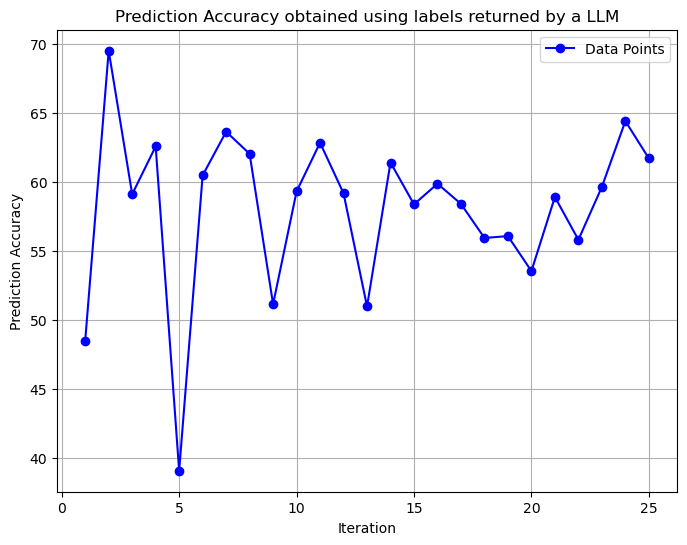

TypeError: can only concatenate str (not "numpy.float64") to str

In [11]:
from ollama import chat
import ast
import matplotlib.pyplot as plt

MAX_ITERATIONS = 25

# Initialize model and variables
model_name = 'qwen2.5:32b'

# Initial label map
label_map = {0: 'World', 1: 'Sports', 2: 'Business', 4: 'Sci/Tech'}
best_accuracy = 48.5
accuracy_data = [48.5]
iteration_data = list(range(1, MAX_ITERATIONS + 1))

initial_interaction = True
# Function to interact with the LLM
def interact_with_llm(model_name, prompt):
    
    stream = chat(
        model=model_name,
        messages=[{'role': 'user', 'content': prompt}],
        stream=True,
    )
    response = ""
    for chunk in stream:
        response += chunk['message']['content']
    new_labels=response.strip()
    print(new_labels)
    dictionary = ast.literal_eval(new_labels)
    return dictionary

# Loop for iterative prompt refinement
iteration = 1
response = ""
while iteration <= MAX_ITERATIONS:
    print(f"\nIteration {iteration}: Current label prompts:")
    for k, v in label_map.items():
        print(f"{k}: \"{v}\"") 
    if(initial_interaction):
        label_map = interact_with_llm(model_name, message)
        initial_interaction = False
    
    else:

        

        # Get outputs from func1 and func2
        results_df, output1, accuracy = perform_error_analysis(ds, classifier, label_map, num_samples=3000)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
        output2 = analyze_error_patterns(results_df)
        accuracy_data.append(accuracy)

        # print(f"func1 output: {output1}")
        # print(f"func2 output: {output2}")
        
        # Prepare input message for the LLM
        llm_input = f"""
            Here are the current prompts for labels:\n{label_map}
            Here is the analysis for your last set of prompts/labels for the data:
            {output1}
            {output2}

            Using this and the current prompts, generate improved prompts for the labels.(print only in the format described and print nothing else, also the prompts should not be questions, rather they should be assertions)
            Output format: {{0: "prompt0", 1: "prompt1", 2: "prompt2", 3: "prompt3"}}"""
    
        print(llm_input)

        # Send current prompts and function outputs to the LLM
        label_map = interact_with_llm(model_name, llm_input)

        

    iteration += 1


plt.figure(figsize=(8, 6))
plt.plot(iteration_data, accuracy_data, marker= 'o', linestyle = '-', color = 'b', label = 'Data Points')

plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title("Prediction Accuracy obtained using labels returned by a LLM")
plt.legend()
plt.grid(True)

plt.show()

print("Best Accuracy: " + best_accuracy)




In [ ]:
import re

# Input string (your data)
data = """

"""

# Regex pattern to find all instances of "Overall Accuracy:" followed by a number
pattern = r"Overall Accuracy:\s*([\d.]+)%"

# Find all matches
accuracies = re.findall(pattern, data)


# Convert to a list of floats
accuracy_list = [float(acc) for acc in accuracies]
accuracy_list.insert(0, 48.50)
# Print the result

print(accuracy_list)


Best Accuracy:  69.5


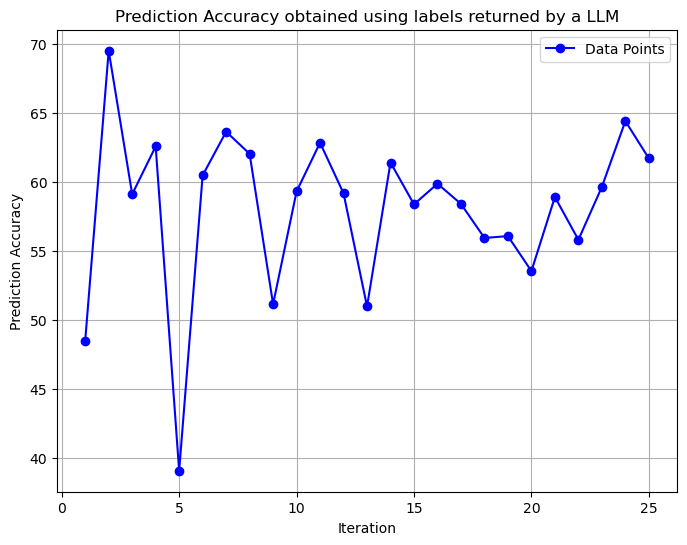

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(iteration_data, accuracy_data, marker= 'o', linestyle = '-', color = 'b', label = 'Data Points')

plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title("Prediction Accuracy obtained using labels returned by a LLM")
plt.legend()
plt.grid(True)



print("Best Accuracy: " , best_accuracy)
plt.savefig('qwen2.5:27b_accuracy.png', dpi = 300, bbox_inches = 'tight')
plt.show()
